# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

550x550 size - images cropped - generated in 01_03_image_mask_cropping

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(0)

In [5]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: ccf97578, DATE: 20191217


In [6]:
UID='37c69040'
DATE='20191217'
NB='02_07_2'

In [7]:
SUBSET_DATA=False
SUBSET_LEN=171

In [8]:
tgt_height = 550
data_dir = Path('data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped/mask_fill/train'
train_mask = train_path/'masks'
train_img = train_path/'images'

test_img = train_images/'cropped/mask_fill/test'


In [9]:
filename = 'data/CAX_LogFacies_Train_File.csv'

In [10]:
file_test = 'data/CAX_LogFacies_Test_File.csv'

#### all data

In [11]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()
    

,0
0,well_0.png
1,well_1.png
2,well_2.png
3,well_3.png
4,well_4.png


In [12]:
test_df = pd.read_csv(file_test)
test_df.head()


,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


### Data

In [13]:
train_img_names = get_image_files(train_img)
len(train_img_names)

28000

In [14]:
train_img_names[:3]

[PosixPath('data/train_images/cropped/mask_fill/train/images/well_3666_crop_3.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/images/well_3886_crop_6.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/images/well_2037_crop_6.png')]

# TODO read in file names

Where n in bw 0 and 6 inclusive

w is 0-x incl for train, x+1-end for test

well_{w}_crop_{n}.png')

In [15]:
for im in train_img_names:
    assert 'crop' in str(im)

In [16]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('data/train_images/cropped/mask_fill/train/masks/well_3666_crop_3.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/masks/well_3886_crop_6.png'),
 PosixPath('data/train_images/cropped/mask_fill/train/masks/well_2037_crop_6.png')]

In [17]:
for im in train_mask_names:
    assert 'crop' in str(im)

### Data QC

In [18]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [19]:
train_img_names[0]

PosixPath('data/train_images/cropped/mask_fill/train/images/well_3666_crop_3.png')

In [20]:
missing_i_m=set(inames) - set(mnames)

In [21]:
missing_m_i= set(mnames)-set(inames) 

In [22]:
assert len(missing_i_m)==len(missing_m_i)==0

In [23]:
len(inames)

28000

In [24]:
len(mnames)

28000

In [25]:
inames.sort()
mnames.sort()

In [26]:
len(inames)

28000

In [27]:
for im,mm in zip(inames, mnames):
    assert im==mm
    img=train_img/f'{im}'
    mmg=train_mask/f'{mm}'
    img_ =pil_image.open(img)
    mmg_ =pil_image.open(mmg)
    if img_.size != mmg_.size:
        print(f'img_.size: {img_.size} != mmg_.size: {mmg_.size}')

data/train_images/cropped/mask_fill/train/images/well_2389_crop_1.png


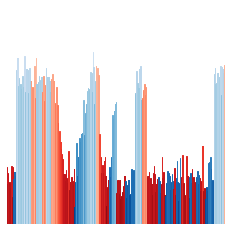

In [28]:
img_f = train_img_names[5]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

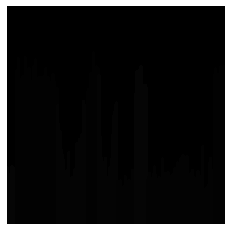

In [29]:
mask_f = train_mask_names[5]
mask_gr = open_image(mask_f)
mask_gr.show(figsize=(18,4))

### Link Masks with Images

In [30]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file name

In [31]:
get_y_fn(img_f)

PosixPath('data/train_images/cropped/mask_fill/train/masks/well_2389_crop_1.png')

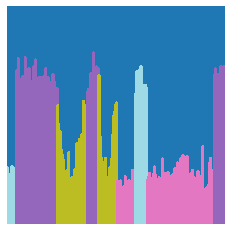

In [32]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [33]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        u_values.extend(np.unique(mask.tolist()))
    return u_values

In [34]:
#u_values=list(set(get_all_uniques(train_mask_names, 100)))
#u_values.sort()
#print(u_values)

Note that not all colours are mapped by fastai - we need to do this manually

### Log Facies

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [35]:
#codes = array(['Background', 'None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'])
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

In [36]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([275, 275]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [5, 5, 5,  ..., 2, 2, 2],
          [5, 5, 5,  ..., 2, 2, 2],
          [5, 5, 5,  ..., 2, 2, 2]]]))

In [37]:
gr_size = np.array(img_gr.shape[1:])
gr_size,img_gr.data

(array([275, 275]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7137, 0.7725, 0.7176,  ..., 0.7294, 0.7020, 0.9882],
          [0.7137, 0.7725, 0.7176,  ..., 0.7294, 0.7020, 0.9882],
          [0.7137, 0.7725, 0.7176,  ..., 0.7294, 0.7020, 0.9882]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.0745, 0.0902, 0.0745,  ..., 0.8392, 0.8275, 0.7020],
          [0.0745, 0.0902, 0.0745,  ..., 0.8392, 0.8275, 0.7020],
          [0.0745, 0.0902, 0.0745,  ..., 0.8392, 0.8275, 0.7020]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1

## Datasets

In [38]:
bs = 8
#size=src_size//2
#squish to square

size=(tgt_height, tgt_height)

In [39]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1.1, max_lighting=0.0, \
                    max_warp=0., p_affine=0., p_lighting=0.0)

In [40]:
src = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file('../val_20pct_2.csv', path=train_img)
    .label_from_func(get_y_fn, classes=codes))

In [41]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [42]:
len(src.train.x)

22400

In [43]:
#src_test = (SegmentationItemList.from_folder(path=train_img)
#    .label_empty()
#    .split_none()
#    .add_test_folder(test_folder='../../test', tfms=None, tfm_y=False))

In [44]:
#data_test = (src_test.transform(size=size, tfms=None, tfm_y=False)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [45]:
data.train_ds.x[0].shape

torch.Size([3, 275, 275])

In [46]:
#data_test.valid_ds.x[0].shape

In [47]:
data.train_ds.y[0].shape

torch.Size([1, 275, 275])

In [48]:
uy=[]
def get_unique_y_vals(data_list):
    for yt in data_list:
        y=yt.data.numpy()
        uy.extend(np.unique(y.tolist()))
    return uy

In [49]:
#u_values=list(set(get_unique_y_vals(data.train_ds.y)))
#u_values.sort()
#print(u_values)

In [50]:
#y=data.train_ds.y[0].data.numpy()

In [51]:
#np.unique(y)

In [52]:
data.label_list

LabelLists;

Train: LabelList (22400 items)
x: SegmentationItemList
Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550)
y: SegmentationLabelList
ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550)
Path: data/train_images/cropped/mask_fill/train/images;

Valid: LabelList (5600 items)
x: SegmentationItemList
Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550)
y: SegmentationLabelList
ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550)
Path: data/train_images/cropped/mask_fill/train/images;

Test: None

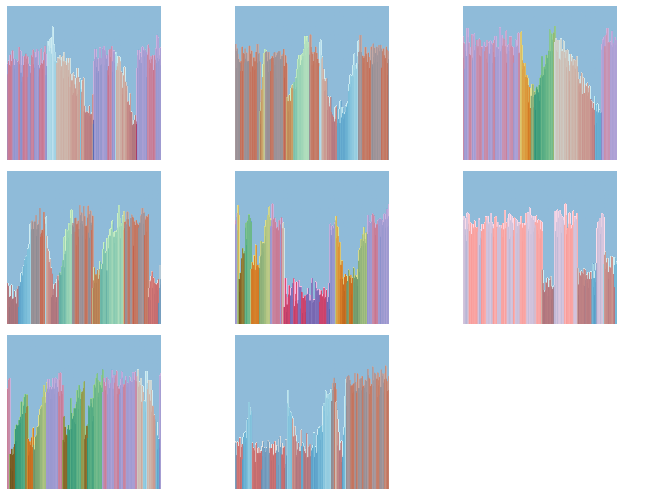

In [53]:
data.show_batch(4, figsize=(10,7))

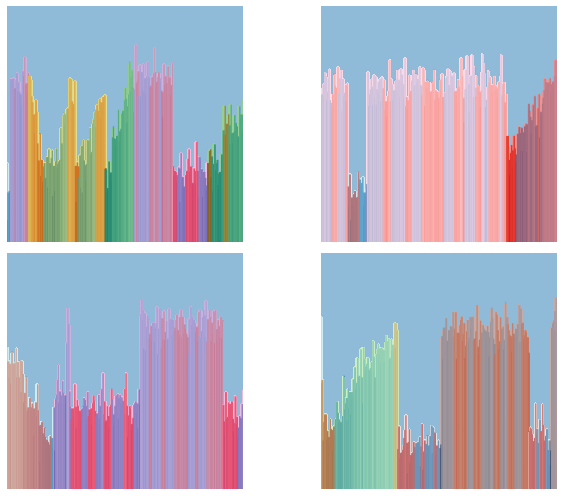

In [54]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [55]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [56]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_camvid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [57]:
data

ImageDataBunch;

Train: LabelList (22400 items)
x: SegmentationItemList
Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550)
y: SegmentationLabelList
ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550)
Path: data/train_images/cropped/mask_fill/train/images;

Valid: LabelList (5600 items)
x: SegmentationItemList
Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550)
y: SegmentationLabelList
ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550)
Path: data/train_images/cropped/mask_fill/train/images;

Test: None

In [58]:
wd=1e-2

In [59]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()

In [60]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [61]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [62]:
#learn.loss_func=dice
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [63]:
#learn.pred_batch()

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


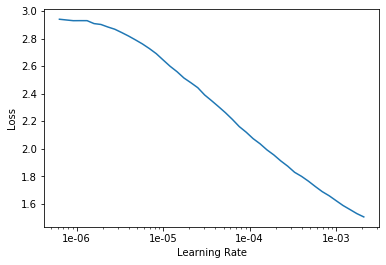

In [65]:
learn.recorder.plot()

In [66]:
lr=5e-4

In [67]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.135679,0.135231,0.926795,29:15


In [68]:
learn.save(f'{NB}-{UID}_unet_squish-s1-r0-{DATE}')

In [69]:
lr=1e-5

In [70]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.124374,0.132759,0.928192,29:37


In [71]:
learn.save(f'{NB}-{UID}_unet_squish-s1_1-r0-{DATE}')

In [72]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.124635,0.131086,0.929013,30:01


In [73]:
learn.save(f'{NB}-{UID}_unet_squish-s1_1-r0-{DATE}')

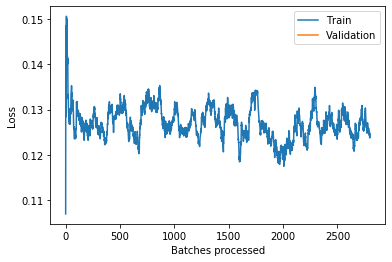

In [74]:
learn.recorder.plot_losses()

### Re-train

In [75]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


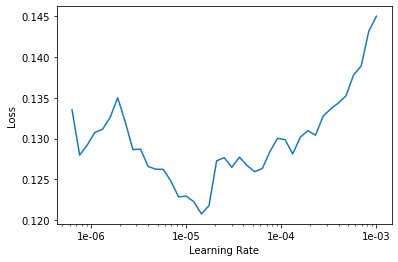

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit_one_cycle(2, slice(5e-6, lr/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.119535,0.122940,0.933856,29:53
1,0.119934,0.121013,0.935191,29:48


In [78]:
learn.save(f'{NB}-{UID}_unet_squish-s2-r0-{DATE}')

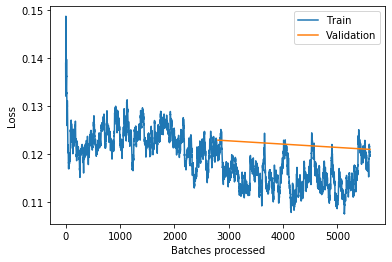

In [79]:
learn.recorder.plot_losses()

### Loss QC

In [80]:
learn.load(f'{NB}-{UID}_unet_squish-s1-r0-{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (22400 items)
x: SegmentationItemList
Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550)
y: SegmentationLabelList
ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550)
Path: data/train_images/cropped/mask_fill/train/images;

Valid: LabelList (5600 items)
x: SegmentationItemList
Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550),Image (3, 550, 550)
y: SegmentationLabelList
ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550),ImageSegment (1, 550, 550)
Path: data/train_images/cropped/mask_fill/train/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [81]:
learn.data.classes

array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'], dtype='<U11')

In [82]:
interp=SegmentationInterpretation.from_learner(learn)

RuntimeError: DataLoader worker (pid 29941) is killed by signal: Killed. 

In [ ]:
top_losses, top_idxs=interp.top_losses((275,275))

In [ ]:
top_losses, top_idxs

In [ ]:
top_losses.shape

In [ ]:
top_idxs.shape

In [ ]:
top_idxs[:20]

In [ ]:
tnp=top_idxs.numpy()
idxs=tnp[tnp<800]

In [ ]:
# show top loss
print(top_losses[idxs[0]])
interp.show_xyz(idxs[0], codes, sz=15)

In [ ]:
interp.show_xyz(idxs[3], codes, sz=15)

### Loss Distribution

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)